### Consumo de combustible: Análisis Exploratorio

In [1]:
import pandas as pd

consumo_2024 = pd.read_excel(
    './Datos_consumos/CONSUMO-HIDROCARBUROS-2024-12.xlsx',
    sheet_name='CONSUMO',
    header=6,
    parse_dates=['Fecha']
)

consumo_2025 = pd.read_excel(
    './Datos_consumos/VENTAS-HIDROCARBUROS-2025-05.xlsx',
    sheet_name='VENTAS_IMP',
    header=6,
    parse_dates=['Fecha']
)

consumo = pd.concat([consumo_2024, consumo_2025], ignore_index=True)
consumo.sort_values('Fecha', inplace=True)

consumo.set_index('Fecha', inplace=True)

diesel_cols = [c for c in consumo.columns if 'Diesel' in c]
consumo['Diesel'] = consumo[diesel_cols].sum(axis=1)

df_consumo = consumo.rename(columns={
    'Gasolina regular': 'Gasolina Regular',
    'Gasolina superior': 'Gasolina Super',
    'Gas licuado de petróleo': 'Gas Licuado'
})[['Gasolina Regular', 'Gasolina Super', 'Diesel', 'Gas Licuado']]

df_consumo.head()


,Gasolina Regular,Gasolina Super,Diesel,Gas Licuado
Fecha,,,,
2000-01-01 00:00:00,202645.20,308156.82,634667.06,194410.476190
2000-02-01 00:00:00,205530.96,307766.31,642380.66,174710.552381
2000-03-01 00:00:00,229499.56,331910.29,699807.25,189234.066667
2000-04-01 00:00:00,210680.40,315648.08,586803.98,174330.607143
2000-05-01 00:00:00,208164.34,319667.97,656948.20,191745.147619


In [2]:
import pandas as pd

df_consumo.index = pd.to_datetime(df_consumo.index, errors='coerce')

df_consumo = df_consumo[df_consumo.index.notna()]

df_consumo = df_consumo[~df_consumo.index.duplicated(keep='first')]

df_consumo = df_consumo[df_consumo.index <= '2025-05-01']

print(df_consumo.shape)  
print("Desde", df_consumo.index.min(), "hasta", df_consumo.index.max())


(305, 4)
Desde 2000-01-01 00:00:00 hasta 2025-05-01 00:00:00


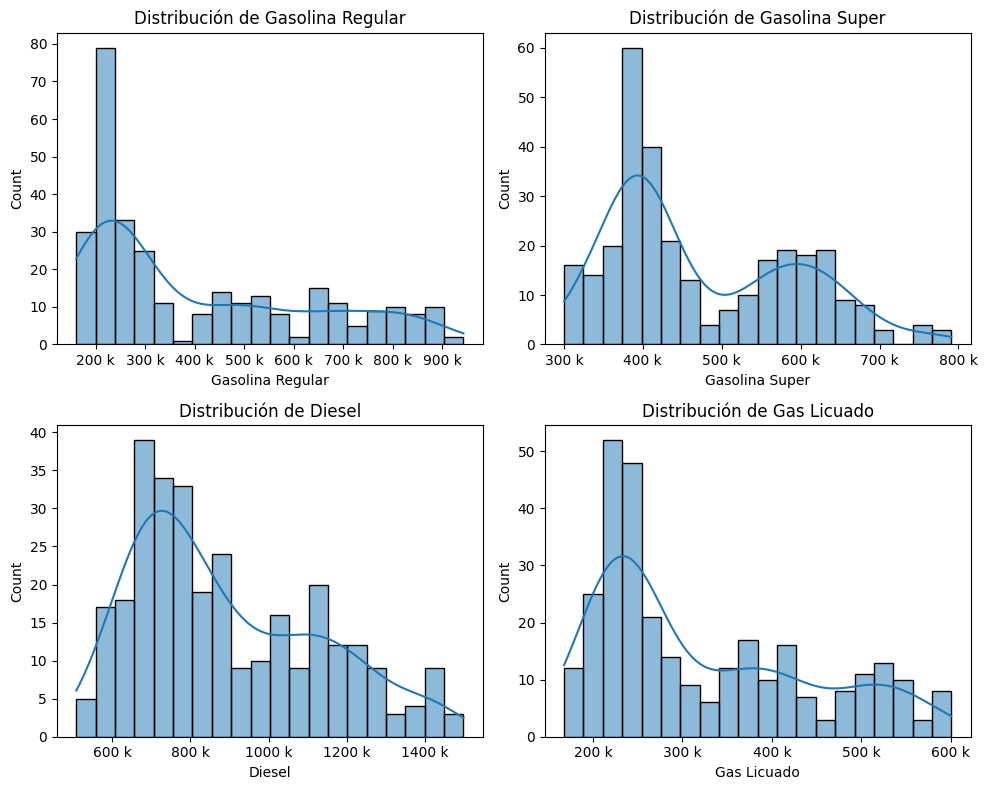

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

k_formatter = mtick.FuncFormatter(lambda x, pos: f'{int(x/1000)} k')

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, col in zip(axes.flatten(), df_consumo.columns):
    sns.histplot(df_consumo[col], bins=20, kde=True, ax=ax)
    ax.set_title(f'Distribución de {col}')
    ax.xaxis.set_major_formatter(k_formatter)
plt.tight_layout()
plt.show()


Se puede observar como los cuatro tipos de combustible poseen una cola hacia la derecha, siendo más notaria en la Gasolina Regular lo cual indica que la mayoría de los meses concentra su consumo en valores bajos‐medios, pero que existen unos pocos meses con consumos excepcionalmente altos que extienden la cola hacia la derecha. Por otro lado vemos con la Super tiene sus picos en valores más altos y pareciera tener un segundo pico más amortiguado. El caso de Diesel es interesante porque parecer ser la que más amortiguación posee teniendo una cola no tan marcada, lo cual indica una distribución más amplia que las otras. Por último tenemos el gas licuado, el cual parece ser aún más estable.

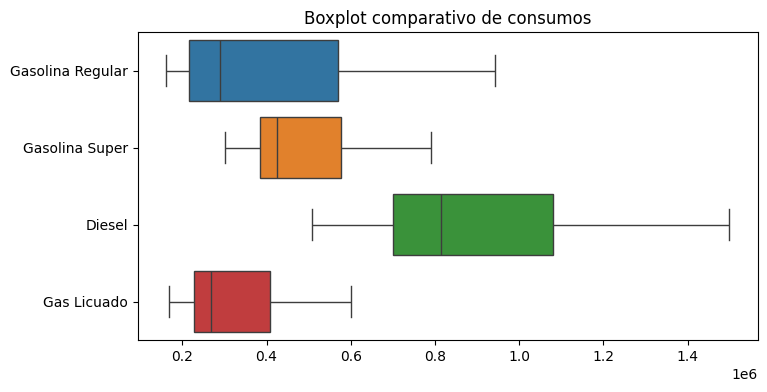

In [7]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_consumo, orient='h')
plt.title('Boxplot comparativo de consumos')
plt.show()





Se puede observar como Diesel es el conbustible que más consume, pero también es el mayor variabilidad. El caso contrario es el gas licuado, el cual es el menos consumido y también el que posee menor dispersión. En medio tenemos la gasolina Super y Regular, siendo Super ligeramente más estable que Regular, pero sin superar al Gas licuado.

Matriz de correlación:
                   Gasolina Regular  Gasolina Super    Diesel  Gas Licuado
Gasolina Regular          1.000000        0.936525  0.930957     0.982216
Gasolina Super            0.936525        1.000000  0.926488     0.925740
Diesel                    0.930957        0.926488  1.000000     0.916637
Gas Licuado               0.982216        0.925740  0.916637     1.000000 



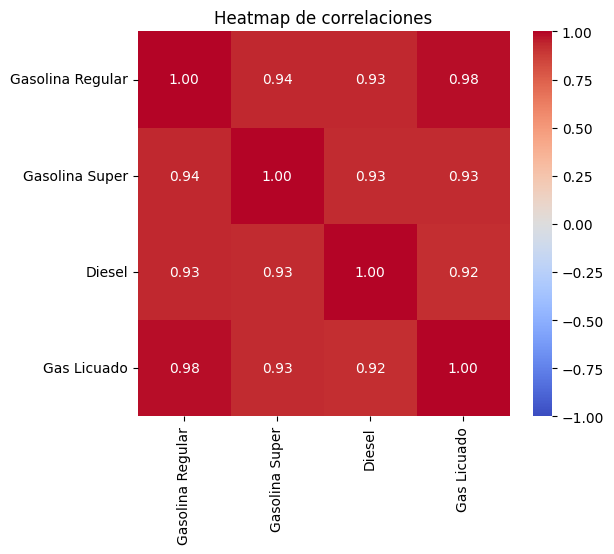

In [5]:
corr = df_consumo.corr()
print("Matriz de correlación:\n", corr, "\n")

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de correlaciones')
plt.show()


Se observa como los 4 tipos de combustible seleccionados poseen una correlación > .90 lo cual es bastante interesante, pero dentro de todas las correlaciones la qeu posee el valor más alto es la de gas licuado - gasolina Regular. Lo cual resulta interesante si contemplamos que el gas licuado es la más estable y Regular era la segunda más variada.